In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/collab/apprentissageGFProfond.zip > /dev/null
!unzip /content/drive/MyDrive/collab/train_non_augmented.zip > /dev/null
!unzip /content/drive/MyDrive/collab/train_augmented.zip > /dev/null
!unzip /content/drive/MyDrive/collab/augmented_noise.zip > /dev/null
!unzip /content/drive/MyDrive/collab/test64.zip > /dev/null
!pip install torcheval > /dev/null

In [ ]:
!unzip /content/drive/MyDrive/collab/new/augmented75.zip > /dev/null
!unzip /content/drive/MyDrive/collab/new/validation.zip > /dev/null

In [ ]:
import os
import copy
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torcheval
import numpy as np
from torcheval.metrics.functional import binary_f1_score
from operator import itemgetter
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torch.nn import Conv2d, Linear
from torch.nn import Dropout
from torch.nn import MaxPool2d, AvgPool2d
from torch.nn import ReLU
from torch.nn.modules.batchnorm import BatchNorm1d, BatchNorm2d
from torch.nn import LogSoftmax, Sigmoid
from torch import flatten
from sklearn.metrics import f1_score

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.targets = self.img_labels.iloc[:, 1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        image = image.to(torch.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# Separate train, test, validation 

augmented = True

if augmented:
  train_set = CustomImageDataset("drive/MyDrive/collab/augmented_train.csv", "augmented")
  test = CustomImageDataset("drive/MyDrive/collab/test64.csv", "augmented2")
  #train = CustomImageDataset("drive/MyDrive/collab/new/augmented75_train_csv.csv", "augmented75")
  #val = CustomImageDataset("drive/MyDrive/collab/new/validation_25.csv", "validation")
  #test = CustomImageDataset("drive/MyDrive/collab/test64.csv", "augmented2")
else:
  train_set = CustomImageDataset("drive/MyDrive/collab/train.csv", "train_non_augmented")
  test = CustomImageDataset("drive/MyDrive/collab/test64.csv", "augmented2")


(train, val) = random_split(train_set, [int(0.75*len(train_set)), int(0.25*len(train_set))], generator=torch.Generator().manual_seed(420))

# Samples reweighting
y_train_indices = train.indices
y_train = [train_set.targets[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))


batchsize = 32
trainldr = DataLoader(dataset=train, batch_size=batchsize, shuffle=True)#, sampler=sampler)
valldr = DataLoader(dataset=val, batch_size=batchsize, shuffle=True)
testldr = DataLoader(dataset=test, batch_size=batchsize, shuffle=True)

print("Training samples : " + str(len(train)))
print("Validation samples : " + str(len(val)))
print("Testing samples : " + str(len(test)))

Training samples : 107766
Validation samples : 35922
Testing samples : 31681


In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR) # trick to ignore warnings

In [ ]:
class LeNet(nn.Module):
    def __init__(self, numChannels, hidensize, classes):
        super(LeNet, self).__init__()
        
        # Dropout
        self.dropout = nn.Dropout(0.25)
        self.relu = ReLU(inplace=True)
        self.norm0 = BatchNorm2d(1)

        # Layer 1
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=30, kernel_size=(5, 5))
        self.norm1 = BatchNorm2d(30)
        self.pool1avg = AvgPool2d(kernel_size=4, stride=1)
        self.pool1max = MaxPool2d(kernel_size=2, stride=1)

        # Layer 2
        self.conv2 = Conv2d(in_channels=30, out_channels=40, kernel_size=(5, 5))
        self.norm2 = BatchNorm2d(40)
        self.pool2max = MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = Conv2d(in_channels=40, out_channels=50, kernel_size=(5, 5))
        self.norm3 = BatchNorm2d(50)
        self.pool3max = MaxPool2d(kernel_size=2, stride=2)

        # Layer 4
        self.conv4 = Conv2d(in_channels=50, out_channels=60, kernel_size=(5, 5))
        self.norm4 = BatchNorm2d(60)
        self.pool4max = MaxPool2d(kernel_size=2, stride=2)

        # Classification
        self.fc1 = Linear(in_features=540, out_features=hidensize)
        self.fc2 = Linear(in_features=hidensize, out_features=hidensize)
        self.fc3 = Linear(in_features=hidensize, out_features=hidensize)
        self.fc4 = Linear(in_features=hidensize, out_features=classes)
        self.activation = LogSoftmax(dim=1)

    def forward(self, x):
        #x = self.norm0(x)
        
        # First Layer
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.pool1avg(x)
        x = self.pool1max(x)
        # Second Layer
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        x = self.pool2max(x)
        # Third Layer
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        x = self.pool3max(x)
        # Fourth Layer
        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu(x)
        x = self.pool4max(x)
        # Linear
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout(x) # Dropouts avoid overfit
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.dropout(x)
        # Classifier
        output = self.activation(x)
        return output

In [ ]:
# Training
hidensize = 500
numepchs = 10
l_r = 0.001
    
device = torch.device("cuda")
modl = LeNet(numChannels=1, hidensize=hidensize, classes=2)
modl.to(device)
info = ""
H = {
	"train_loss": [],
	"train_acc": [],
  "train_f1": [],
	"val_loss": [],
	"val_acc": [],
  "val_f1": []
}

# Optimizer
optim = torch.optim.Adam(modl.parameters(), lr=l_r, weight_decay=1e-5)

# Loss Function
lossFn = nn.CrossEntropyLoss()

for epoch in range(numepchs):
    # Training
    trainLoss = 0
    trainAcc = 0
    trainF1Score = 0
    # Validation
    valLoss = 0
    valAcc = 0
    valF1Score = 0
    for (imgs, lbls) in trainldr:
        (imgs, lbls) = (imgs.cuda(), lbls.cuda())

        outp = modl(imgs)
        losses = lossFn(outp, lbls)

        optim.zero_grad()
        losses.backward()
        optim.step() 
        trainLoss += losses
        trainAcc += (outp.argmax(1) == lbls).type(torch.float).sum().item()
        trainF1Score += binary_f1_score(outp.argmax(1), lbls)

    with torch.no_grad():
        modl.eval()
        for (im, lb) in valldr:   
          (im, lb) = (im.cuda(), lb.cuda())
          pred = modl(im)
          valLoss += lossFn(pred, lb)
          valAcc += (pred.argmax(1) == lb).type(torch.float).sum().item()
          valF1Score += binary_f1_score(pred.argmax(1), lb)

    # Average Losses
    avgTrainLoss = trainLoss / (len(train) // batchsize)
    avgValLoss = valLoss / (len(val) // batchsize)
	  # Average accuracy
    avgTrainAcc = trainAcc / len(train)
    avgValAcc = valAcc / len(val)
    # Average F1 Score
    avgTrainF1Score = trainF1Score / (len(train) // batchsize)
    avgValF1Score = valF1Score / (len(val) // batchsize)
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(avgTrainAcc)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(avgValAcc)
    H["train_f1"].append(avgTrainF1Score.cpu())
    H["val_f1"].append(avgValF1Score.cpu())
    
    info1 = "[INFO] EPOCH: {}/{}\n".format(epoch + 1, numepchs)
    info2 = "Train loss: {:.6f}, Train accuracy: {:.4f}, F1 Score : {:.4f}\n".format(avgTrainLoss, avgTrainAcc, avgTrainF1Score)
    info3 = "Val loss: {:.6f}, Val accuracy: {:.4f}, F1 Score : {:.4f}\n".format(avgValLoss, avgValAcc, avgValF1Score)
    info += (info1 + info2 + info3)
    print(info1 + info2 + info3)

[INFO] EPOCH: 1/10
Train loss: 0.276073, Train accuracy: 0.9024, F1 Score : 0.6890
Val loss: 0.249154, Val accuracy: 0.9062, F1 Score : 0.7218

[INFO] EPOCH: 2/10
Train loss: 0.206620, Train accuracy: 0.9182, F1 Score : 0.7428
Val loss: 0.183425, Val accuracy: 0.9287, F1 Score : 0.7802

[INFO] EPOCH: 3/10
Train loss: 0.189325, Train accuracy: 0.9249, F1 Score : 0.7665
Val loss: 0.175802, Val accuracy: 0.9298, F1 Score : 0.7835

[INFO] EPOCH: 4/10
Train loss: 0.179972, Train accuracy: 0.9293, F1 Score : 0.7835
Val loss: 0.169170, Val accuracy: 0.9355, F1 Score : 0.8087

[INFO] EPOCH: 5/10
Train loss: 0.174807, Train accuracy: 0.9308, F1 Score : 0.7849
Val loss: 0.173297, Val accuracy: 0.9330, F1 Score : 0.7914

[INFO] EPOCH: 6/10
Train loss: 0.169464, Train accuracy: 0.9333, F1 Score : 0.7978
Val loss: 0.170305, Val accuracy: 0.9344, F1 Score : 0.7899

[INFO] EPOCH: 7/10
Train loss: 0.165333, Train accuracy: 0.9343, F1 Score : 0.7968
Val loss: 0.158728, Val accuracy: 0.9368, F1 Score : 

Test loss: 0.115317, test accuracy: 0.9530, F1 Score: 0.6351



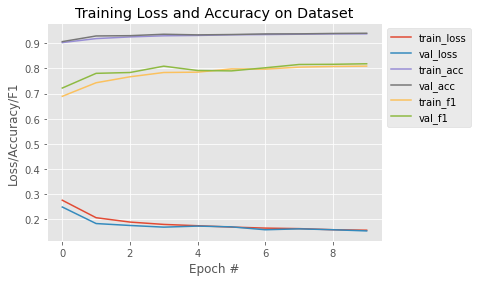

In [ ]:
dir = "/content/drive/MyDrive/collab/test7/"
os.mkdir(dir)
#torch.save(modl.state_dict(), dir + "/model")
#modl.load_state_dict(torch.load("/content/drive/MyDrive/collab/model"))

incorrect_examples = []
incorrect_labels = []
incorrect_pred = []
testLoss = 0
testAcc = 0
f1Score = 0

modl.eval()
with torch.no_grad():
    for imgs, lbls in testldr:
        (imgs, lbls) = (imgs.to(device), lbls.to(device))

        pred = modl(imgs)
        testLoss += lossFn(pred, lbls)
        testAcc += (pred.argmax(1) == lbls).type(torch.float).sum().item()
        f1Score += binary_f1_score(pred.argmax(1), lbls)

        # Print misspredicted
        out = pred.argmax(dim=1, keepdim=True)
        idxs_mask = ((out == lbls.view_as(out))==False).view(-1)
        if idxs_mask.numel(): 
            incorrect_examples.append(imgs[idxs_mask].squeeze().cpu().numpy())
            incorrect_labels.append(imgs[idxs_mask].cpu().numpy())
            incorrect_pred.append(pred[idxs_mask].argmax(1).squeeze().cpu().numpy()) 

# Specs
avgTestLoss = testLoss / (len(test) // batchsize)
avgF1 = f1Score / (len(test) // batchsize)
avgTestAcc = testAcc / len(test)

strr = "Test loss: {:.6f}, test accuracy: {:.4f}, F1 Score: {:.4f}\n".format(avgTestLoss, avgTestAcc, avgF1)
print(strr)
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.plot(H["train_f1"], label="train_f1")
plt.plot(H["val_f1"], label="val_f1")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy/F1")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig(dir + "graph", bbox_inches = 'tight')

torch.save(modl, dir + "model")
fp = open(dir + 'performance.txt', 'w')
fp.write(strr)
fp.close()
fp = open(dir + 'logs.txt', 'w')
fp.write(info)
fp.close()

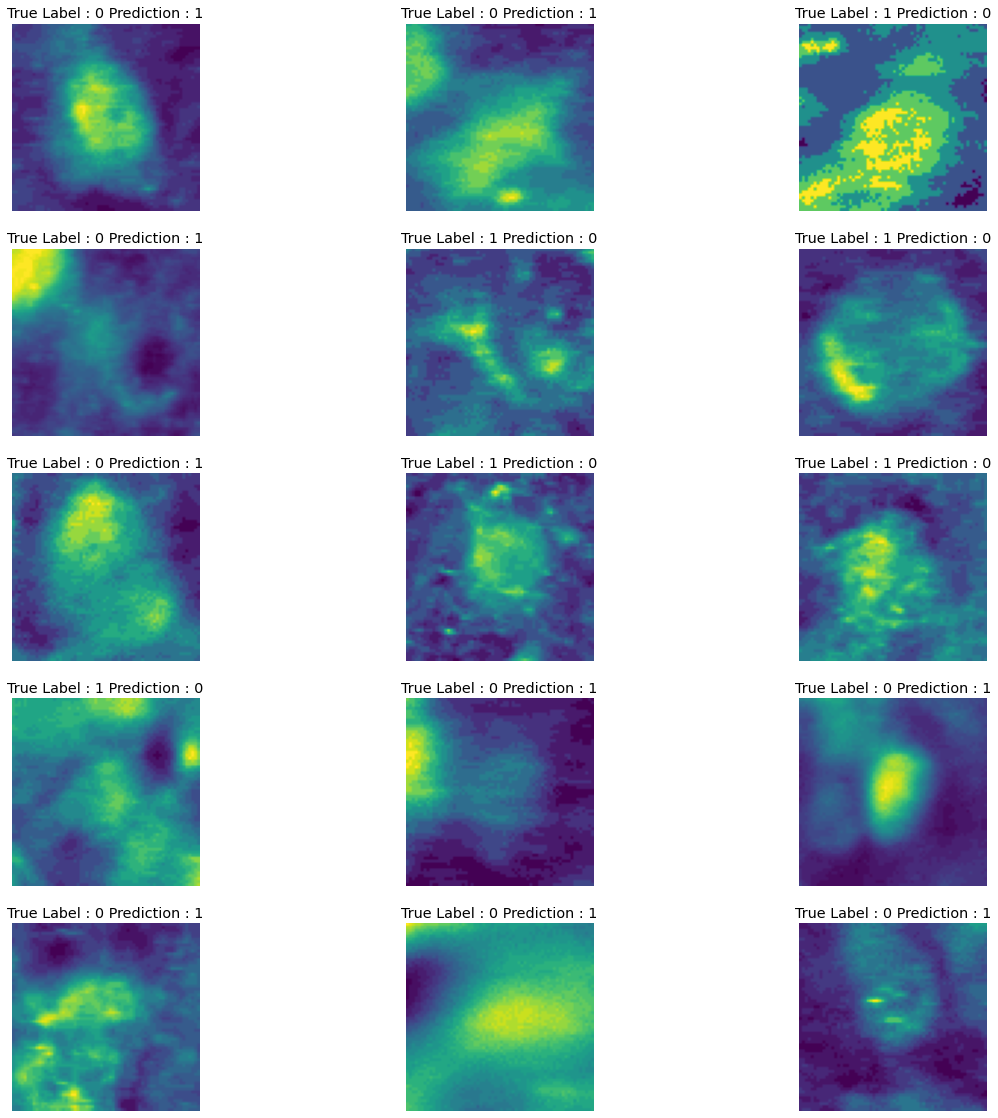

In [ ]:
# Misspredicted images
plt.figure(figsize=(20, 20))
count = 0

for (img, pred) in zip(incorrect_labels, incorrect_pred):
    if not count < 15:
        break
    if len(pred.shape):
      for i, p in zip(img, pred):
          ax = plt.subplot(5, 3, count + 1)
          count += 1
          plt.imshow(i.reshape((64, 64)).astype("uint8"))
          plt.title("True Label : "+ str(int(1-p)) + " Prediction : "+ str(int(p)))
          plt.axis("off")
          if not count < 15:
            break